In [1]:

import os
import sys
import numpy as np

import numpy as np
import warnings
warnings.filterwarnings('ignore')
from rdkit import Chem, RDLogger
from rdkit.Chem import rdchem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
import pandas as pd
import swifter

RDLogger.DisableLog("rdApp.info")

IPythonConsole.molSize = 450, 450

import pandas as pd

from importlib import reload
from ML.util import tm

from compare_smiles_code import check_smiles
import compare_smiles_code

from hydrogen_parser import *
from xyz2mol_tm.NBO_to_smiles.mol_utils import ALLOWED_OXIDATION_STATES


# *MolHash(Chem.RemoveHs(Chem.MolFromSmiles(a)), HashFunction.CanonicalSmiles)


IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.useSVG = True
IPythonConsole.drawOptions.minFontSize = 24
# IPythonConsole.drawOptions.legendFraction = 0.2
IPythonConsole.molSize = 500, 500

def print_to_file(line,file_name):
    with open(f"{file_name}", "a") as f:
        f.write(line + "\n")

In [4]:
s1 = Chem.MolFromSmiles("C[Si](C)(C)[c-]12->[Ru+2]345(<-[C-]#[O+])(<-[C-]#[O+])(<-[C-]#[O+])<-c16c->3([c-]->4([Si](C)(C)C)c->52=O)COC6")
s2 = Chem.MolFromSmiles("C[Si](C)(C)C12->[Ru]34(<-[C-]#[O+])(<-[C-]#[O+])(<-[C-]#[O+])<-C=15COCC->35=C->4([Si](C)(C)C)C2=O")

# Highlight different cases and differences between the SMILES obtained with the 3 methods

This notebooks illustrates various problems and differences between SMILES sets. 

### Load the smiles sets

In [2]:
combined_frame = pd.read_csv("../SMILES_csvs/tmqmg_smiles.csv")

### Instantiate masks checking for invalid smiles values

In [3]:
mask_csd = combined_frame["smiles_CSD_fix"].apply(check_smiles)
mask_tmqmg = combined_frame["smiles_NBO_DFT_xyz"].apply(check_smiles)
mask_huckel = combined_frame["smiles_huckel_DFT_xyz"].apply(check_smiles)

### How many smiles for each method?

In [4]:
# Aligning the print statements
print(f"CSD smiles:     {len(combined_frame[mask_csd]):>5} / {len(combined_frame):>5}")
print(f"NBO smiles:     {len(combined_frame[mask_tmqmg]):>5} / {len(combined_frame):>5}")
print(f"Huckel smiles:  {len(combined_frame[mask_huckel]):>5} / {len(combined_frame):>5}")
print(f"3 valid SMILES: {len(combined_frame[mask_csd & mask_tmqmg & mask_huckel]):>5} / {len(combined_frame):>5}")


CSD smiles:     53320 / 60799
NBO smiles:     46190 / 60799
Huckel smiles:  59878 / 60799
3 valid SMILES: 41355 / 60799


In [5]:
not_valid_smiles = combined_frame[~(mask_csd | mask_tmqmg | mask_huckel)]
print(f"{len(not_valid_smiles)} does not have a valid SMILES for either approach")
print("We remove them from the dataframe")

758 does not have a valid SMILES for either approach
We remove them from the dataframe


In [6]:
combined_frame.drop(not_valid_smiles.index.values, inplace=True)

### SMILES with incorrect formulas (missing hydrogens)

In [7]:

mask_csd = combined_frame["smiles_CSD_fix"].apply(check_smiles)
mask_tmqmg = combined_frame["smiles_NBO_DFT_xyz"].apply(check_smiles)
mask_huckel = combined_frame["smiles_huckel_DFT_xyz"].apply(check_smiles)
df = combined_frame[(mask_csd | mask_tmqmg | mask_huckel)]

In [8]:
df["number_hydrogen_csd_api"] = df["formula_heaviest_fragment"].apply(parse_formula,task="hydrogen")

In [9]:
# Step 2: Apply the function only to the rows where the mask is True
df['formula_huckel_smiles'] = np.nan  # Initialize with NaN
df.loc[mask_huckel, 'formula_huckel_smiles'] = df.loc[mask_huckel, 'smiles_huckel_DFT_xyz'].swifter.apply(get_formula_from_smiles)

df['formula_csd_smiles'] = np.nan  # Initialize with NaN
df.loc[mask_csd, 'formula_csd_smiles'] = df.loc[mask_csd, 'smiles_CSD_fix'].swifter.apply(get_formula_from_smiles)

df['formula_nbo_smiles'] = np.nan  # Initialize with NaN
df.loc[mask_tmqmg, 'formula_nbo_smiles'] = df.loc[mask_tmqmg, 'smiles_NBO_DFT_xyz'].swifter.apply(get_formula_from_smiles)


Pandas Apply: 100%|██████████| 46190/46190 [00:11<00:00, 3905.11it/s]


In [10]:
df["number_hydrogen_huckel_formula"] = df.swifter.apply(
    lambda x: parse_formula(
        x.formula_huckel_smiles,
        task="hydrogen",
    ),
    axis=1,
)
df["number_hydrogen_csd_formula"] = df.swifter.apply(
    lambda x: parse_formula(
        x.formula_csd_smiles,
        task="hydrogen",
    ),
    axis=1,
)
df["number_hydrogen_nbo_formula"] = df.swifter.apply(
    lambda x: parse_formula(
        x.formula_nbo_smiles,
        task="hydrogen",
    ),
    axis=1,
)

Pandas Apply: 100%|██████████| 60041/60041 [00:00<00:00, 79988.15it/s]


In [24]:

csd_arr = df[mask_csd]["number_hydrogen_csd_formula"]
ground_truth = df["number_hydrogen_csd_api"]
nbo_arr = df[mask_tmqmg]["number_hydrogen_nbo_formula"]
huckel_arr = df[mask_huckel]["number_hydrogen_huckel_formula"]

csd_comp = csd_arr != ground_truth[mask_csd]
nbo_comp = nbo_arr != ground_truth[mask_tmqmg]
huckel_comp = huckel_arr != ground_truth[mask_huckel]

print(f"Number of missing hydrogens for each method:\n")
print(f"CSD {sum(csd_comp)}")
print(f"NBO: {sum(nbo_comp)}")
print(f"Huckel: {sum(huckel_comp)}")



Number of missing hydrogens for each method:

CSD 650
NBO: 569
Huckel: 967


In [19]:
all_wrong_formula = df[(csd_comp & nbo_comp & huckel_comp)]
print(f"{len(all_wrong_formula)} Entries have wrong or missing formula for all methods. We drop them")

0 Entries have wrong or missing formula for all methods. We drop them


In [13]:
df.drop(all_wrong_formula.index.values, inplace=True)

In [27]:
len(df)

60041

# Problematic smiles

### Incorrect overall charge

The Huckel and NBO SMILES by design have the correct overall charge. However, the CSD fixed SMILES can potentially have wrong overall charges as the ligand charges are adjusted. 

In [55]:
m = df[mask_csd]
wrong_overall_charge = []
for i, row in m.iterrows():
    dict1 = {}
    mol = Chem.MolFromSmiles(row["smiles_CSD_fix"])
    charge = Chem.GetFormalCharge(mol)

    form_charge = int(row["charge"])

    if charge != int(form_charge):
        wrong_overall_charge.append(row.to_dict())

df_overall_charge = pd.DataFrame(wrong_overall_charge)
print(f"{len(df_overall_charge)} of the fixed CSD smiles have the incorrect overall charge")

123 of the fixed CSD smiles have the incorrect overall charge


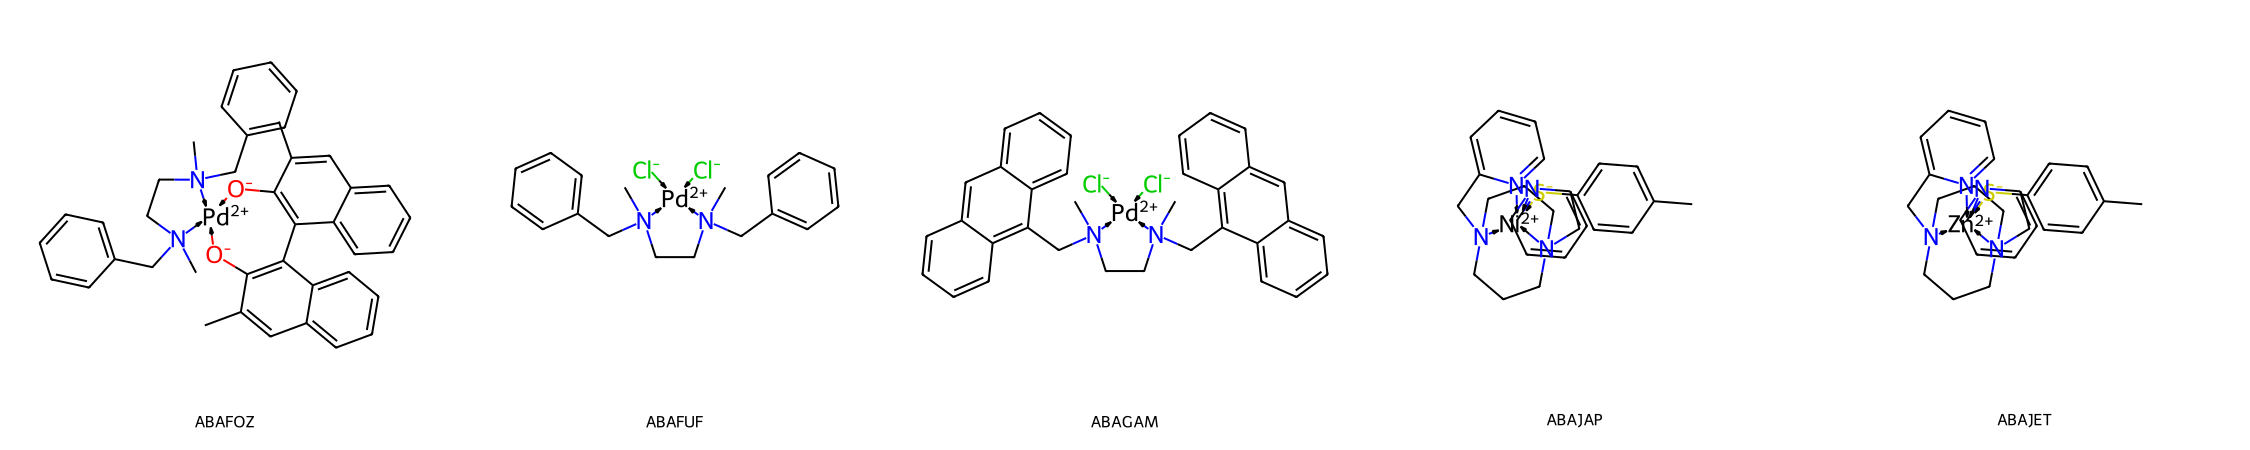

In [56]:
example_mols = [Chem.MolFromSmiles(x) for x in m["smiles_CSD_fix"][0:5]]
identifiers = [x for x in m["IDs"][0:5]]
Chem.Draw.MolsToGridImage(example_mols,subImgSize=(450,450),molsPerRow=5,maxMols=5, legends = identifiers)

### Incorrect ligand charge leads to charged rings

Due to the cutoff nature of the charge assignment in the NBO, some ligands can be assigned incorrect charges. We see many cases where a ligand is assigned a charge of -2, where it should be a neutral one.
As a result, some of the NBO SMILES have rings with alternating positive and negative charges. Examples of this are illustrated below.

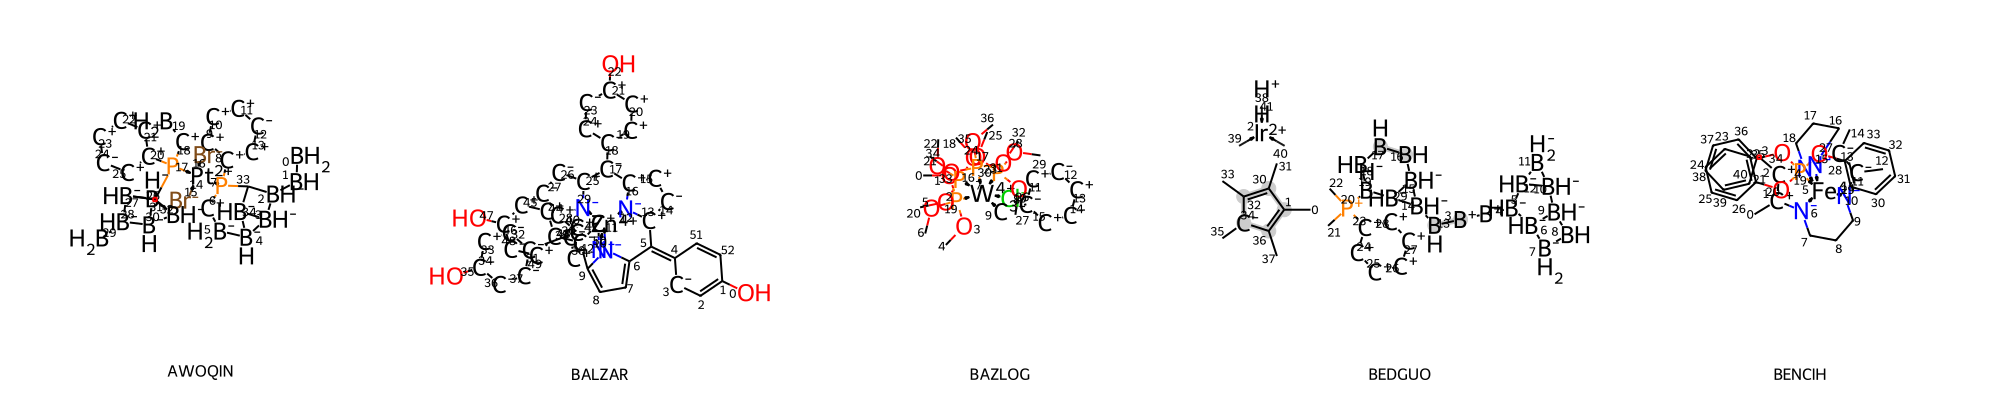

In [20]:
df_nbo = df[mask_tmqmg]
df_huckel = df[mask_huckel]
mols = []
for ids, s2 in zip(df_nbo["IDs"], df_huckel["smiles_huckel_DFT_xyz"]):
    m2 = Chem.MolFromSmiles(s2)

    rings = Chem.GetSSSR(m2)
    if len(rings) > 0:
        for ring in rings:
            charges = [
                m2.GetAtomWithIdx(idx).GetFormalCharge()
                for idx in list(ring)
                if m2.GetAtomWithIdx(idx).GetFormalCharge() != 0
            ]
        if len(charges) > 4:
            mols.append((ids, Chem.DativeBondsToHaptic(m2)))

df_charged_rings = pd.DataFrame(mols, columns=["IDs","mols"])
Chem.Draw.MolsToGridImage(
    df_charged_rings["mols"],
    legends=df_charged_rings["IDs"].to_list(),
    molsPerRow=5,
    subImgSize=(400, 400),
    maxMols=5,
)

In [21]:
print(f"{len(df_charged_rings)} of the NBO SMILES have super charged rings")

122 of the NBO SMILES have super charged rings


### SMILES that have different coordinating atoms 

As the Huckel and NBO SMILES are based on DFT optimized structures, the coordination environment around the TM can be different. 
In this regard, the CSD SMILEs can be seen as the ground truth. 
Below we illustrate some examples from the Huckel SMILES where the bonds to the TM differ compared to the CSD SMILES.

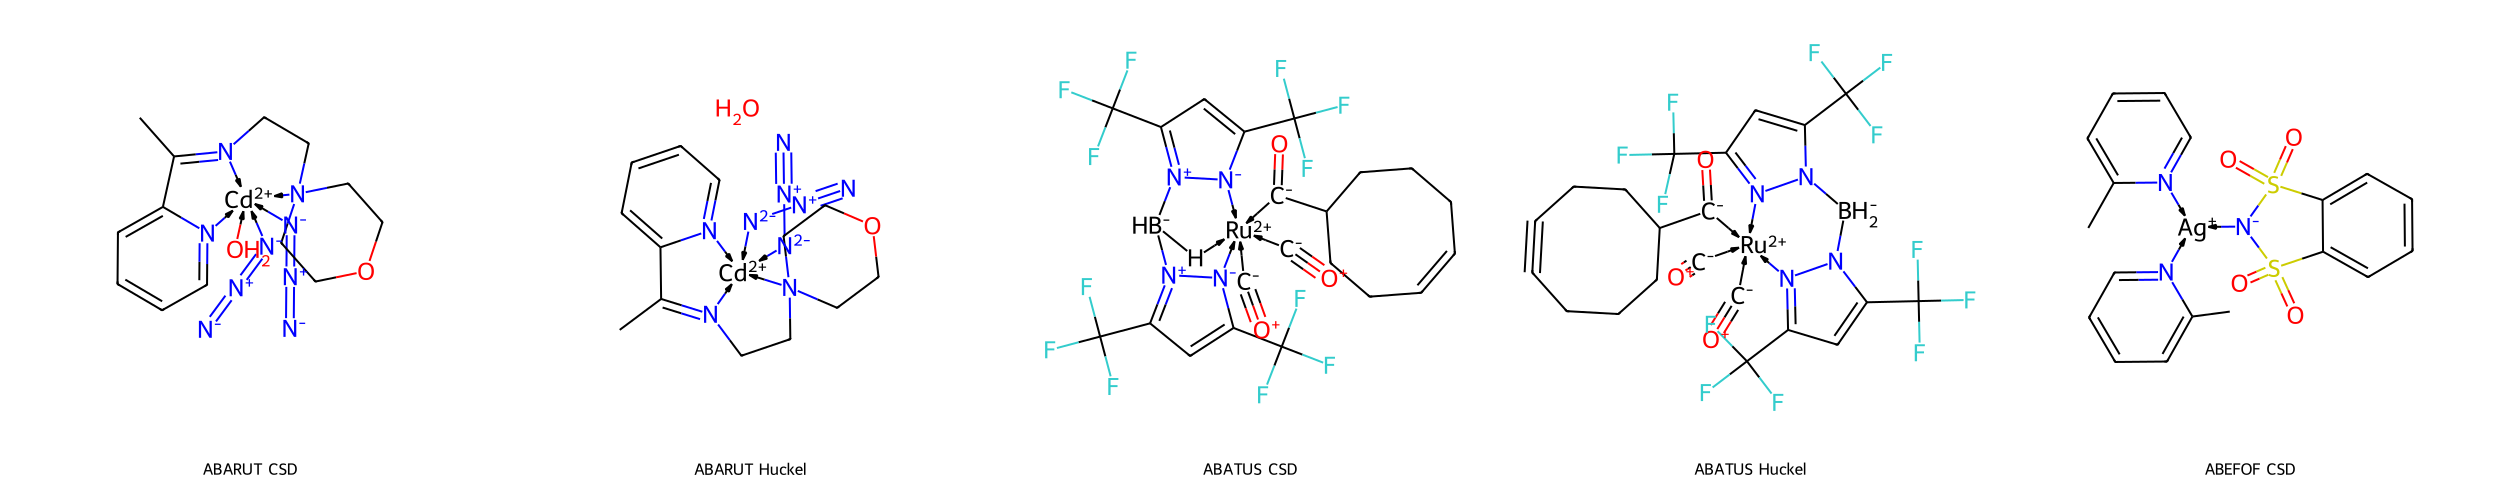

In [61]:
df_compare_coordination = df[mask_csd & mask_huckel]

mols = []
for i, (ids, s2, s3) in enumerate(zip(
    df_compare_coordination["IDs"],
    df_compare_coordination["smiles_CSD_fix"],
    df_compare_coordination["smiles_huckel_DFT_xyz"],
)):
    # mols.append((id+' CSD',Chem.MolFromSmiles(s1, sanitize=False)))
    m2 = Chem.MolFromSmiles(s2)
    m3 = Chem.MolFromSmiles(s3)

    a_m2 = m2.GetAtomWithIdx(m2.GetSubstructMatch(Chem.MolFromSmarts(tm))[0])
    elements_m2 = [x.GetSymbol() for x in a_m2.GetNeighbors()]
    a_m3 = m3.GetAtomWithIdx(m2.GetSubstructMatch(Chem.MolFromSmarts(tm))[0])
    elements_m3 = [x.GetSymbol() for x in a_m3.GetNeighbors()]

    if set(elements_m2) != set(elements_m3):
        mols.append((ids + " CSD",Chem.DativeBondsToHaptic(m2)))
        mols.append((ids+ " Huckel",Chem.DativeBondsToHaptic(m3)))
        # mols.append((ids + ' xyz2mol',Chem.DativeBondsToHaptic(m3)))

    # if i == 1000:
    #     break

df_different_coordination = pd.DataFrame(mols, columns=["IDs","mols"])
Chem.Draw.MolsToGridImage(
    df_different_coordination["mols"],
    legends=df_different_coordination["IDs"].to_list(),
    molsPerRow=6,
    subImgSize=(500, 500),
    maxMols=6,
)

In [62]:
print(f"{len(df_different_coordination)} of the huckel SMILES have different connectivity to the transition metal")

142 of the huckel SMILES have different connectivity to the transition metal


### SMILES that have different TM oxidation states

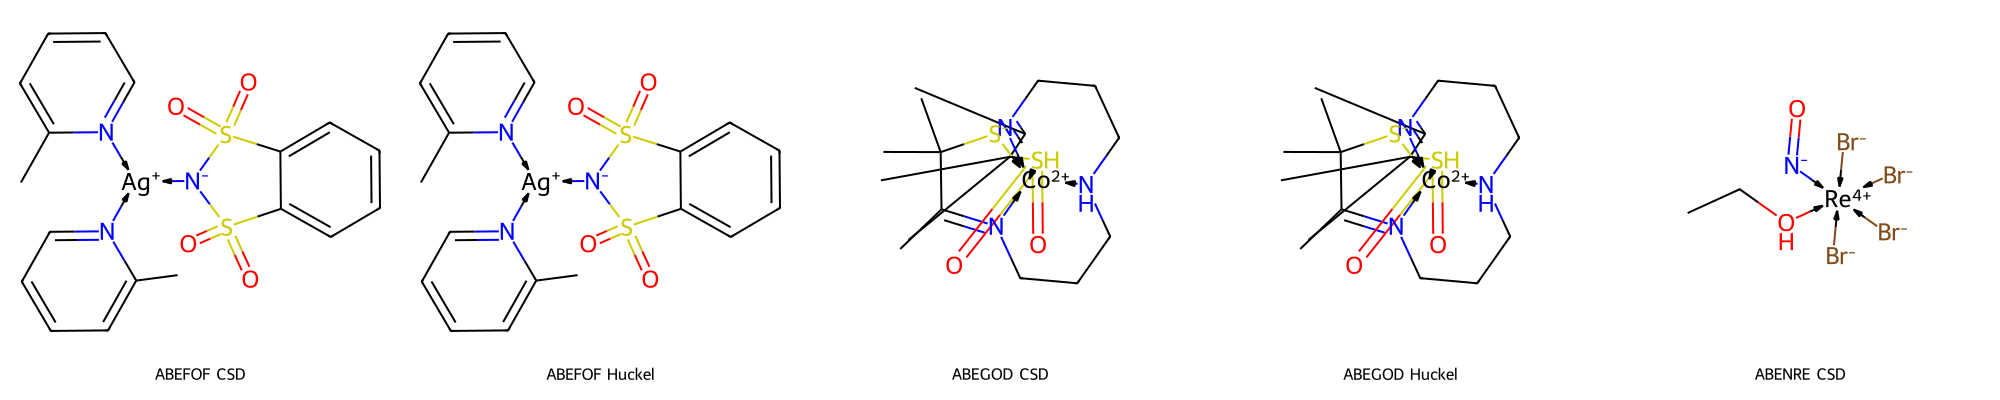

In [65]:

df_compare_oxidation = df[mask_csd & mask_huckel]


mols = []
for ids, s2, s3 in zip(
    df_compare_oxidation["IDs"],
    df_compare_oxidation["smiles_CSD_fix"],
    df_compare_oxidation["smiles_huckel_DFT_xyz"],
):
    m2 = Chem.MolFromSmiles(s2)
    m3 = Chem.MolFromSmiles(s3)

    # Get TM atom
    match2 = m2.GetSubstructMatches(Chem.MolFromSmarts(tm))
    match3 = m3.GetSubstructMatches(Chem.MolFromSmarts(tm))

    if (
        m2.GetAtomWithIdx(match2[0][0]).GetFormalCharge()
        != m3.GetAtomWithIdx(match3[0][0]).GetFormalCharge()
    ):
        mols.append((ids + " CSD", Chem.DativeBondsToHaptic(m2)))
        mols.append((ids + " Huckel", Chem.DativeBondsToHaptic(m3)))
        # mols.append((ids + ' xyz2mol',Chem.DativeBondsToHaptic(m3)))


df_different_tm_odidation_state = pd.DataFrame(mols, columns=["IDs", "mols"])
Chem.Draw.MolsToGridImage(
    df_different_tm_odidation_state["mols"],
    legends=df_different_tm_odidation_state["IDs"].to_list(),
    molsPerRow=6,
    subImgSize=(400, 400),
    maxMols=6,
)

In [66]:
print(f"{len(df_different_tm_odidation_state)} of the huckel SMILES have different oxidation states to the transition metal compared to the CSD SMILES")

10904 of the huckel SMILES have different oxidation states to the transition metal compared to the CSD SMILES


### Problematic hydrides

Dealing with hydride ligands can be challenging in RDKit. Hydrides are attached to the TM atom instead of beeing separate datively bond ligands. This can lead to incorrect oxidation state of the transition metal if the user is unaware.
Below we show a single example of this. We can see that for the huckel and NBO SMILES, the hydride is attached to the TM instead of beeing seen as a separate ligand. 

In [17]:
df[df["IDs"] == "JOWLEM"]

,smiles_NBO_DFT_xyz,IDs,formula_heaviest_fragment,charge,smiles_CSD_fix,smiles_huckel_CSD_xyz,smiles_huckel_DFT_xyz
22870,NaN,JOWLEM,C18 H44 Cl1 P2 Rh1,0.0,CC(C)P(C(C)C)(C(C)C)->[RhH2+](<-[Cl-])<-P(C(C)...,CC(C)P(C(C)C)(C(C)C)->[RhH2+](<-[Cl-])<-P(C(C)...,CC(C)P(C(C)C)(C(C)C)->[RhH2+](<-[Cl-])<-P(C(C)...


In [18]:
m = Chem.MolFromSmiles(
    df[df["IDs"] == "JOWLEM"]["smiles_CSD_fix"].item()
)
m2 = Chem.MolFromSmiles(
    df[df["IDs"] == "JOWLEM"]["smiles_huckel_DFT_xyz"].item()
)

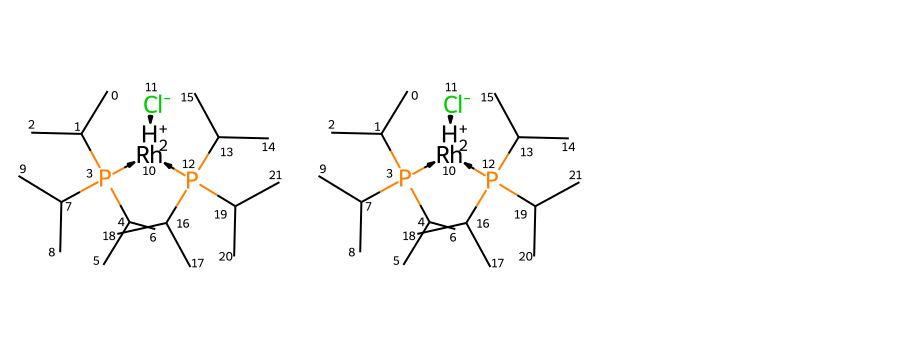

In [29]:
Chem.Draw.MolsToGridImage([m,m2],subImgSize=(300,350))

If we just ask for the formal charge of the TM atom it will not be correct

In [31]:
m.GetAtomWithIdx(10).GetFormalCharge()

1

The overall charge of the complex is zero. Therefore we have -1 Cl + 2*(-1)H + x = 0

Meaning that the correct oxidation state of the Rh is 3+

NB! When disconnecting the ligand, the two hydrides will still be attached to the metal.

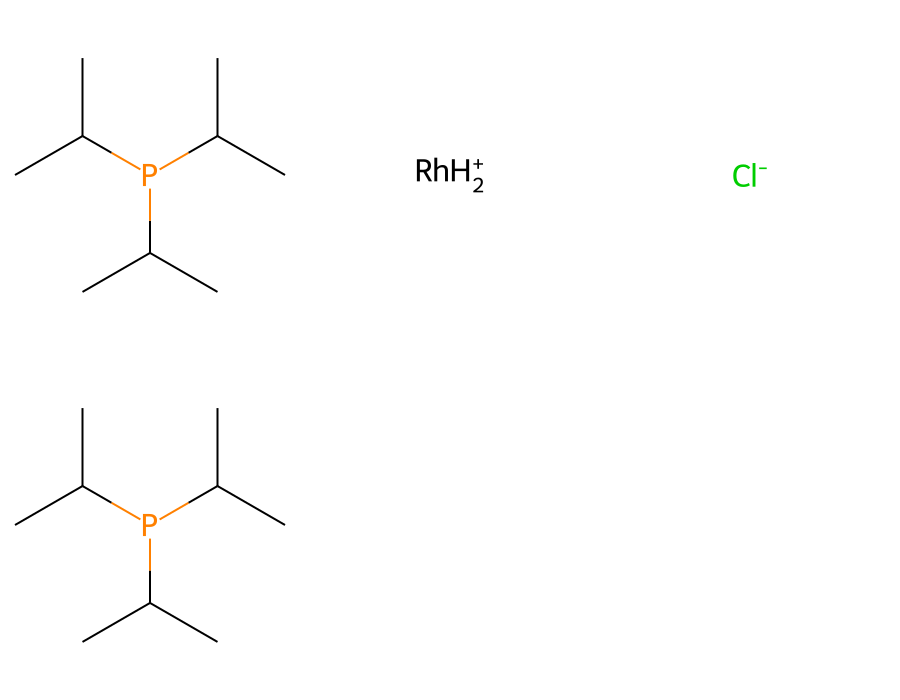

In [22]:
disconnected_mol = compare_smiles_code.mdis.Disconnect(m)
ms = Chem.GetMolFrags(disconnected_mol, asMols=True)
Chem.Draw.MolsToGridImage(ms,subImgSize=(300,350))

## Non-standard TM oxidation states

Some SMILES have non-standard oxidation states for the TM
We have a list of common oxidation states for all TM atoms and if the TM does not have an oxidation state in this list, it is non-standard

In [80]:
ALLOWED_OXIDATION_STATES

{'Sc': [3],
 'Ti': [3, 4],
 'V': [2, 3, 4, 5],
 'Cr': [2, 3, 4, 6],
 'Mn': [2, 3, 4, 6, 7],
 'Fe': [2, 3],
 'Co': [2, 3],
 'Ni': [2],
 'Cu': [1, 2],
 'Zn': [2],
 'Y': [3],
 'Zr': [4],
 'Nb': [3, 4, 5],
 'Mo': [2, 3, 4, 5, 6],
 'Tc': [2, 3, 4, 5, 6, 7],
 'Ru': [2, 3, 4, 5, 6, 7, 8],
 'Rh': [1, 3],
 'Pd': [2, 4],
 'Ag': [1],
 'Cd': [2],
 'La': [3],
 'Hf': [4],
 'Ta': [3, 4, 5],
 'W': [2, 3, 4, 5, 6],
 'Re': [2, 3, 4, 5, 6, 7],
 'Os': [3, 4, 5, 6, 7, 8],
 'Ir': [1, 3],
 'Pt': [2, 4],
 'Au': [1, 3],
 'Hg': [1, 2]}

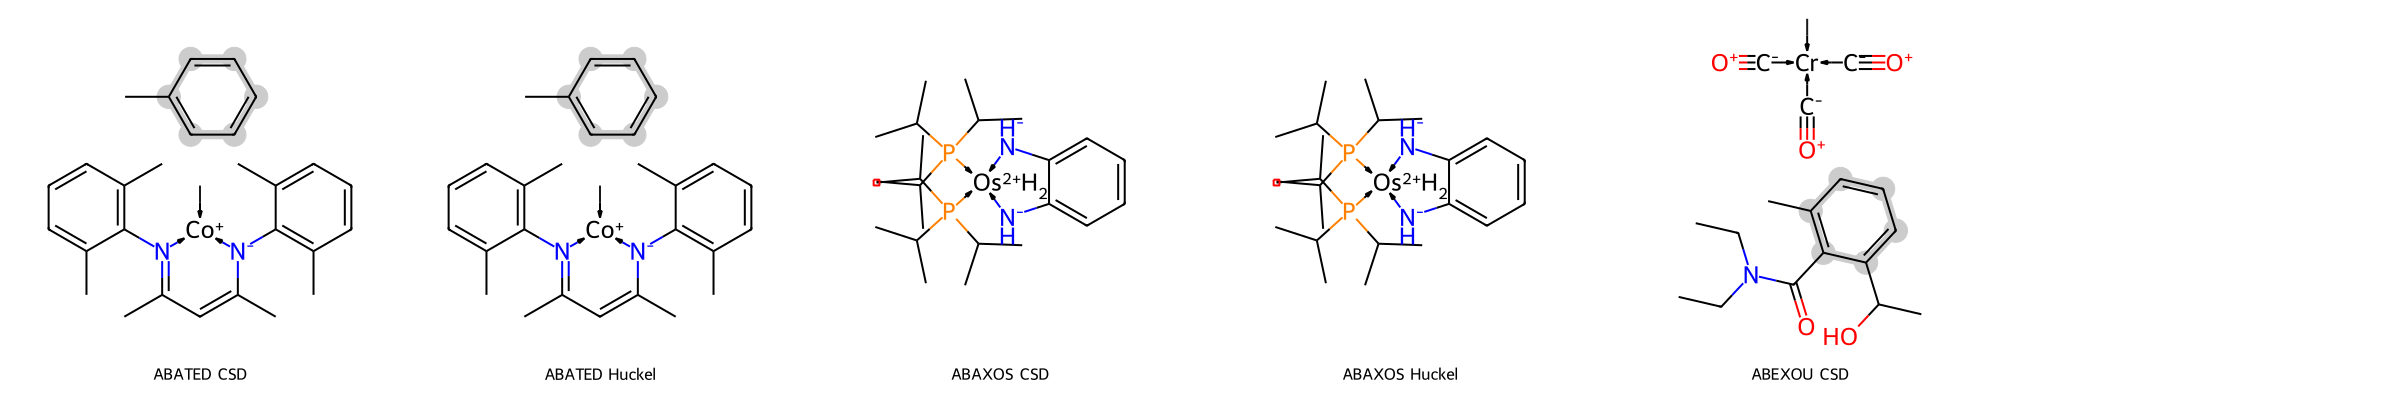

In [81]:
df_non_standard_oxidation = df[mask_csd & mask_huckel]


mols = []
for ids, s2, s3 in zip(
    df_non_standard_oxidation["IDs"],
    df_non_standard_oxidation["smiles_CSD_fix"],
    df_non_standard_oxidation["smiles_huckel_DFT_xyz"],
):
    # mols.append((id+' CSD',Chem.MolFromSmiles(s1, sanitize=False)))
    m2 = Chem.MolFromSmiles(s2)
    m3 = Chem.MolFromSmiles(s3)

    # Get TM atom
    match2 = m2.GetSubstructMatches(Chem.MolFromSmarts(tm))
    match3 = m3.GetSubstructMatches(Chem.MolFromSmarts(tm))

    metal2 = m2.GetAtomWithIdx(match2[0][0])
    metal3 = m3.GetAtomWithIdx(match3[0][0])

    metal2_charge = metal2.GetFormalCharge()
    metal3_charge = metal3.GetFormalCharge()
    if (
        metal2_charge not in ALLOWED_OXIDATION_STATES[metal2.GetSymbol()]
    ) and metal3_charge not in ALLOWED_OXIDATION_STATES[metal3.GetSymbol()]:
        mols.append((ids + " CSD",Chem.DativeBondsToHaptic(m2)))
        mols.append((ids +" Huckel",Chem.DativeBondsToHaptic(m3)))
        # mols.append((ids,ids + ' xyz2mol',Chem.DativeBondsToHaptic(m3)))


df_non_standard_oxidation = pd.DataFrame(mols, columns=["IDs","mols"])
Chem.Draw.MolsToGridImage(
    df_non_standard_oxidation["mols"],
    legends=df_non_standard_oxidation["IDs"].to_list(),
    molsPerRow=6,
    subImgSize=(400, 400),
    maxMols=6,
)

In [ ]:
print(f"{len(df_non_standard_oxidation)} SMILES have non-standard oxidation states for both the fixed CSD SMILES and the huckel SMILES")

## 2+ vs 0 oxidation state

In [11]:
df_check_ox = df[mask_tmqmg & mask_huckel]


mols = []

mols_reverse=[]
for ids, s2, s3 in zip(
    df_check_ox["IDs"],
    df_check_ox["smiles_NBO_DFT_xyz"],
    df_check_ox["smiles_huckel_DFT_xyz"],
):
    m2 = Chem.MolFromSmiles(s2)
    m3 = Chem.MolFromSmiles(s3)

    # Get TM atom
    match2 = m2.GetSubstructMatches(Chem.MolFromSmarts(tm))
    match3 = m3.GetSubstructMatches(Chem.MolFromSmarts(tm))

    metal2 = m2.GetAtomWithIdx(match2[0][0])
    metal3 = m3.GetAtomWithIdx(match3[0][0])

    metal2_charge = metal2.GetFormalCharge()
    metal3_charge = metal3.GetFormalCharge()
    if (
        metal2_charge == 2
    ) and (metal3_charge == 0):
        mols.append((ids + " NBO",Chem.DativeBondsToHaptic(m2)))
        mols.append((ids +" Huckel",Chem.DativeBondsToHaptic(m3)))
        # mols.append((ids,ids + ' xyz2mol',Chem.DativeBondsToHaptic(m3)))
    if (
        metal2_charge == 0
    ) and (metal3_charge == 2):
        mols_reverse.append((ids + " NBO",Chem.DativeBondsToHaptic(m2)))
        mols_reverse.append((ids +" Huckel",Chem.DativeBondsToHaptic(m3)))
        # mols.append((ids,ids + ' xyz2mol',Chem.DativeBondsToHaptic(m3)))
    


df_check_ox = pd.DataFrame(mols, columns=["IDs","mols"])

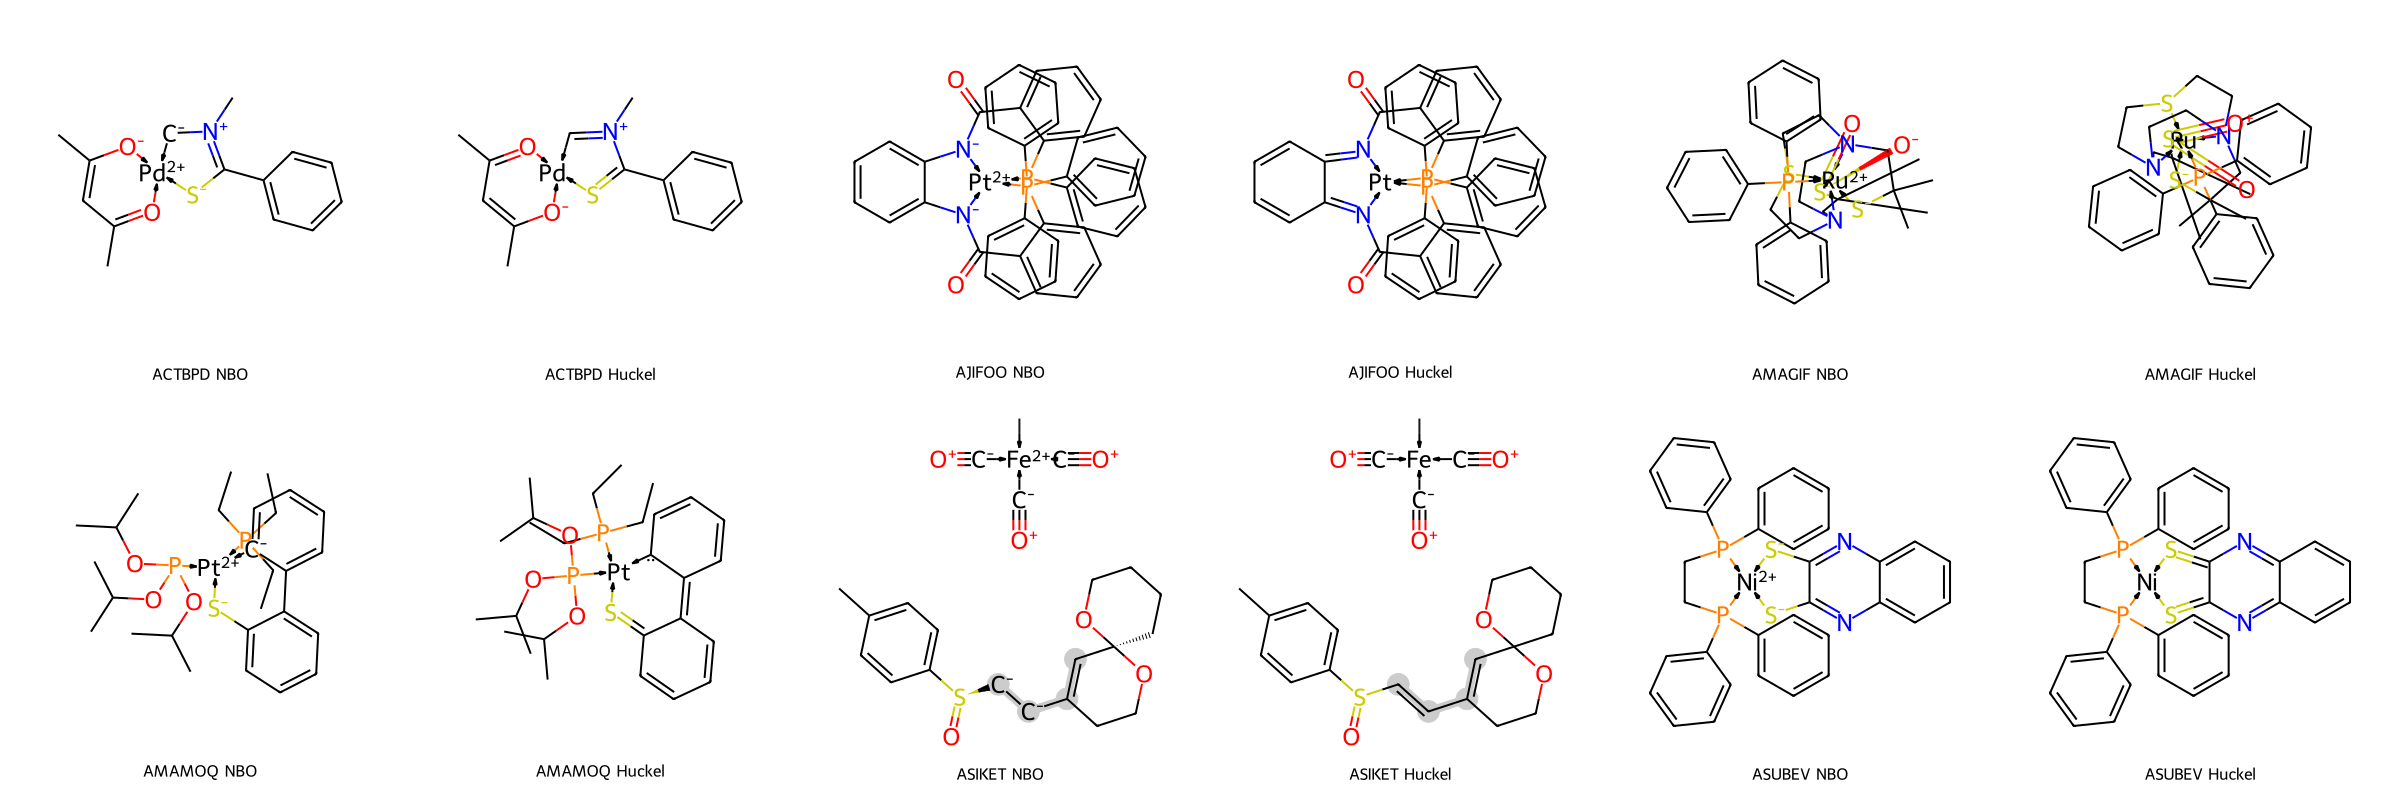

In [12]:

Chem.Draw.MolsToGridImage(
    df_check_ox["mols"],
    legends=df_check_ox["IDs"].to_list(),
    molsPerRow=6,
    subImgSize=(400, 400),
    maxMols=12,
)

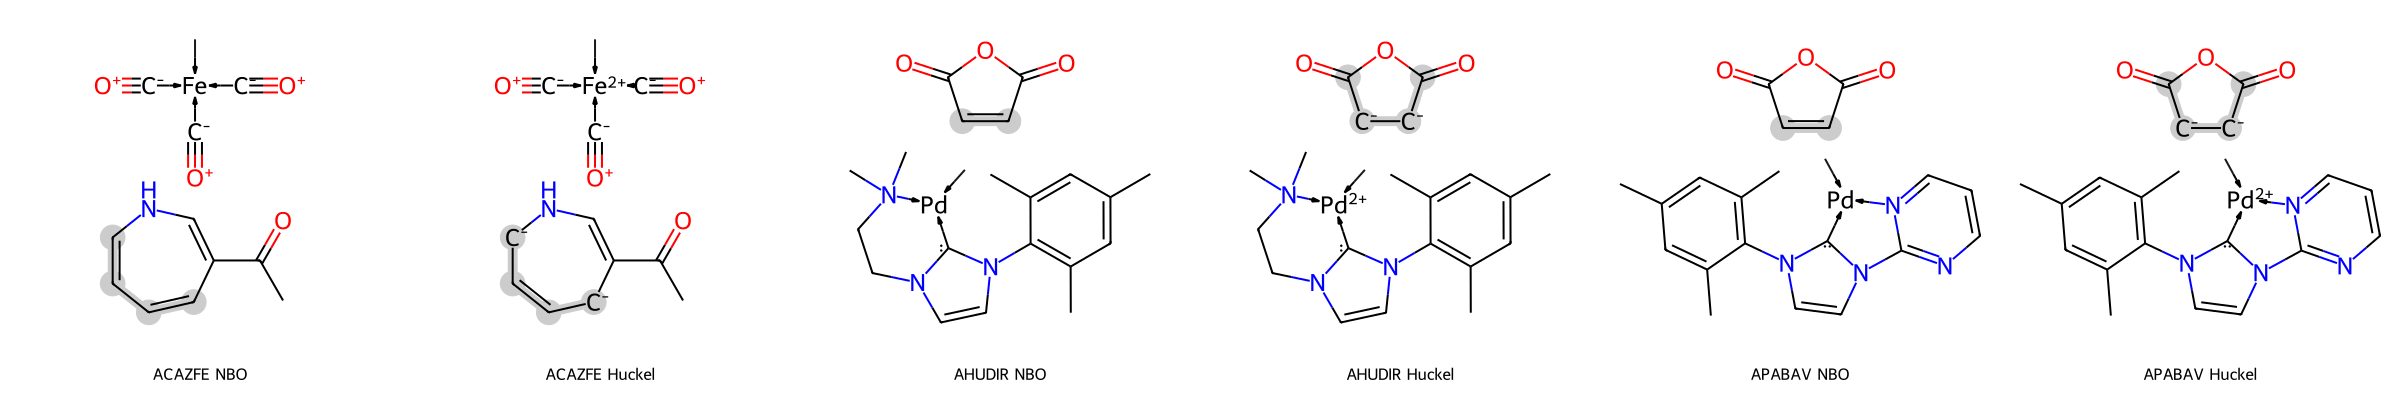

In [13]:
df_check_ox_reverse = pd.DataFrame(mols_reverse, columns=["IDs","mols"])
Chem.Draw.MolsToGridImage(
    df_check_ox_reverse["mols"],
    legends=df_check_ox_reverse["IDs"].to_list(),
    molsPerRow=6,
    subImgSize=(400, 400),
    maxMols=6,
)

In [14]:
len(df_check_ox)

1166

In [15]:
len(df_check_ox_reverse)

262

In [32]:
draw = draw2d(df_check_ox_reverse["mols"][2]).GetDrawingText()

In [33]:
with open("/home/magstr/git/xyz2mol_tm_jensengroup/tmc_smiles_paper/si_examples/plusminustw_2_nbo.svg","w") as f:
    f.write(draw)

In [18]:
from io import BytesIO
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor

def draw2d(
    mol: Chem.Mol,
    legend: str = None,
    atomLabels: dict = None,
    atomHighlights: dict = None,
    size=(800, 600),
    blackwhite=True,
):
    """Create 2D depiction of molecule for publication.

    Args:
        mol (Chem.Mol): Molecule to render
        legend (str, optional): Legend string. Defaults to None.
        atomLabels (dict, optional): Dictionary of atomindices and atomlabels, f.x.:
                                     {17: 'H<sub>1</sub>', 18: 'H<sub>2</sub>'}.
                                     Defaults to None.
        atomHighlights (dict, optional): List of atoms to highlight,, f.x.:
                                         [(9, False, (0.137, 0.561, 0.984)),
                                         (15, True, (0, 0.553, 0))]
                                         First item is the atomindex, second is whether
                                         or not the highlight should be filled, and third
                                         is the color.
                                         Defaults to None.
        size (tuple, optional): Size of the drawing canvas. Defaults to (800, 600).
        blackwhite (bool, optional): Black and white color palet. Defaults to True.

    Returns:
        PIL.PNG: Image of the molecule.
    """
    d2d = Draw.MolDraw2DSVG(*size)
    rdDepictor.Compute2DCoords(mol)
    rdDepictor.NormalizeDepiction(mol)
    rdDepictor.StraightenDepiction(mol)
    dopts = d2d.drawOptions()
    dopts.legendFraction = 0.15
    dopts.legendFontSize = 45
    dopts.baseFontSize = 0.8
    dopts.additionalAtomLabelPadding = 0.1
    dopts.bondLineWidth = 1
    dopts.prepareMolsBeforeDrawing = True
    dopts.scaleBondWidth = False
    if blackwhite:
        dopts.useBWAtomPalette()
    if atomLabels:
        for key, value in atomLabels.items():
            dopts.atomLabels[key] = value

    if legend:
        d2d.DrawMolecule(mol, legend=legend)
    else:
        d2d.DrawMolecule(mol)

    alpha = 0.4
    positions = []
    radii = []
    colors = []
    filled_bools = []
    if atomHighlights:
        for h in atomHighlights:
            filled = False
            color = (0.137, 0.561, 0.984)
            if isinstance(h, int):
                atomIdx = h
            elif len(h) == 2:
                atomIdx, filled = h
            elif len(h) == 3:
                atomIdx, filled, color = h
            else:
                raise ValueError("Invalid atom highlight {}".format(h))
            point = mol.GetConformer().GetAtomPosition(int(atomIdx))
            positions.append(Point2D(point.x, point.y))
            radii.append(0.35)
            colors.append(color)
            filled_bools.append(bool(filled))

        # draw filled circles first
        for pos, radius, color, filled in zip(positions, radii, colors, filled_bools):
            if filled:
                color = (color[0], color[1], color[2], alpha)
                d2d.SetColour(color)
                d2d.SetFillPolys(True)
                d2d.SetLineWidth(0)
                d2d.DrawArc(pos, radius, 0.0, 360.0)

        # # now draw molecule again
        d2d.SetLineWidth(3)
        if legend:
            d2d.DrawMolecule(mol, legend=legend)
        else:
            d2d.DrawMolecule(mol)

        # now draw ring highlights
        for pos, radius, color, filled in zip(positions, radii, colors, filled_bools):
            d2d.SetColour(color)
            d2d.SetFillPolys(False)
            # d2d.SetLineWidth(2.5)
            d2d.SetLineWidth(5)
            d2d.DrawArc(pos, radius, 0.0, 360.0)

        # and draw molecule again for whatever reason
        d2d.SetLineWidth(1)
        if legend:
            d2d.DrawMolecule(mol, legend=legend)
        else:
            d2d.DrawMolecule(mol)

        # now draw ring highlights again
        for pos, radius, color, filled in zip(positions, radii, colors, filled_bools):
            if not filled:
                d2d.SetColour(color)
                d2d.SetFillPolys(False)
                # d2d.SetLineWidth(2.5)
                d2d.SetLineWidth(5)
                d2d.DrawArc(pos, radius, 0.0, 360.0)
    # finish drawing
    d2d.FinishDrawing()
    d2d.GetDrawingText()
    #bio = BytesIO(d2d.GetDrawingText())
    #img = Image.open(bio)
    return d2d